# Introduction
The goal of this notebook is to apply different ML algorithms to preform regression on a car sales data to select the best algorithm for this purpose. That is, based on basic car data (model, power, fuel type, transmission, mileage and age), to choose the ML algorithms that predicts the cost of the car the best. 

In [7]:
import pandas as pd
import numpy as np

In [8]:
import time

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams.update(plt.rcParamsDefault)

In [10]:
#from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Read Data

In [11]:
car_data_ML = pd.read_csv('car_data_ML.csv')
car_data_ML.head(3)

,Unnamed: 0,brand,model,price_in_euro,power_ps,transmission_type,fuel_type,mileage_in_km,car_age
0,0,alfa-romeo,Alfa Romeo GTV,1300.0,201.0,Manual,Petrol,160500.0,27.7
1,3,alfa-romeo,Alfa Romeo Spider,4900.0,150.0,Manual,Petrol,189500.0,27.9
2,5,alfa-romeo,Alfa Romeo Spider,7900.0,150.0,Manual,Petrol,47307.0,27.2


# Data Selection
The ML algorithm selection is made based on a single car a close as it is possible based on the dataset. Each model is processed at once by the ML algorithm to avoid excessive memory usage. So for each car model an separate ML model is created. 

The dataset is grouped by models so that the model becomes an index in the dateframe and can be selected using this index when looping though the models later on. A good choice seems to be the most popular car VW Golf with 150 hp, manual transmission and pertrol engine. The issue here is that the number of datapoints is not enough for a single generation of VW Golf, therefore the age is limited to 11 years with encopasses VW Golf VI to VIII.

Creating a list of car models

In [12]:
car_data_ML.sort_values(by='price_in_euro',ascending=False).head(3)

,Unnamed: 0,brand,model,price_in_euro,power_ps,transmission_type,fuel_type,mileage_in_km,car_age
89446,93699,lamborghini,Lamborghini,5890500.0,770.0,Automatic,Petrol,65.0,4.8
89584,93840,lamborghini,Lamborghini,3250000.0,818.0,Automatic,Hybrid,177.0,1.6
102000,106583,mercedes-benz,Mercedes-Benz SLR,2490000.0,650.0,Automatic,Petrol,15793.0,16.4


In [13]:
car_data_ML = car_data_ML[(car_data_ML['model']=='Volkswagen Golf') &\
                          (car_data_ML['power_ps']==150) &\
                          (car_data_ML['transmission_type']=='Manual') &\
                            (car_data_ML['fuel_type']=='Petrol') &\
                          (car_data_ML['car_age']<11)]                       

# Machine Learning

In [14]:
car_data_ML

,Unnamed: 0,brand,model,price_in_euro,power_ps,transmission_type,fuel_type,mileage_in_km,car_age
217834,227427,volkswagen,Volkswagen Golf,15650.0,150.0,Manual,Petrol,84500.0,8.8
217837,227430,volkswagen,Volkswagen Golf,13300.0,150.0,Manual,Petrol,79000.0,8.8
217863,227457,volkswagen,Volkswagen Golf,14444.0,150.0,Manual,Petrol,111300.0,8.9
218077,227672,volkswagen,Volkswagen Golf,15950.0,150.0,Manual,Petrol,112741.0,9.1
218285,227881,volkswagen,Volkswagen Golf,14900.0,150.0,Manual,Petrol,106000.0,8.8
...,...,...,...,...,...,...,...,...,...
235769,245671,volkswagen,Volkswagen Golf,32448.0,150.0,Manual,Petrol,10.0,0.3
235800,245702,volkswagen,Volkswagen Golf,28990.0,150.0,Manual,Petrol,10.0,0.2
235986,245901,volkswagen,Volkswagen Golf,29475.0,150.0,Manual,Petrol,10.0,0.1
236016,245937,volkswagen,Volkswagen Golf,36480.0,150.0,Manual,Petrol,4900.0,0.3


**The remaining dateset consists of 240 datapoints and should be enough to get an idea how the different algorithms perform**

## Creating Pipeline
Using a scikit learn pipeline a function that loops through the previously created list of car models the same piece of code can be reused to try out several ML algorhithms to compare the peformance.

In [15]:
def predict(steps,car_data_ML):
    #print(steps)
    start = time.time()
    r2 = []
    mape = []
    #car_data_ML = car_data_ML.loc[model].reset_index()
    cat_feat = car_data_ML[['transmission_type','fuel_type']]
    cont_feat = car_data_ML[['price_in_euro','power_ps','mileage_in_km','car_age']]
    dummies = pd.get_dummies(cat_feat,drop_first=False)
    car_data_ML = pd.concat([cont_feat,dummies],axis=1)
    y = car_data_ML['price_in_euro'].values
    X = car_data_ML.drop(columns=['price_in_euro']).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    pipeline = make_pipeline(*steps)
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test) 
    r2.append(r2_score(y_test, predictions))
    mape.append(mean_absolute_percentage_error(y_test, predictions))
    end = time.time()
    print(f'Completed in {np.round((end - start),decimals=2)} seconds\n\
Mean r2 value for all models is {np.round(sum(r2)/len(r2),decimals=2)}\n\
Mean mape value for all models is {np.round(sum(mape)/len(mape)*100,decimals=1)} %')
    return((X_train,y_train,X_test,y_test,predictions))      

## Creating plot function to visualize the perfromance of an ML algorithm

In [16]:
def plot_results(X_train,y_train,X_test,y_test,predictions):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,5),sharey=True)
    fig.tight_layout()
    ax1.scatter(x=X_train[:,1],y=y_train,color='blue',alpha=0.5,label='y_train')
    ax1.set_title('Training Data')
    ax1.set_ylabel('Price in Euro')
    ax1.legend()
    ax2.scatter(x=X_test[:,1],y=y_test,color='blue',alpha=0.5,label='y_test')
    ax2.scatter(x=X_test[:,1],y=predictions,color='red',alpha=0.5,label='predictions')
    ax2.set_title('Testing Data vs Predictions')
    ax2.legend()
    fig.text(0.5,-0.02, "Mileage in km", ha="center", va="center")
    plt.show() 

## Training and Predictions

### Linear Regression

In [17]:
(X_train,y_train,X_test,y_test,predictions) = predict((MinMaxScaler(), LinearRegression()),car_data_ML)

Completed in 0.05 seconds
Mean r2 value for all models is 0.55
Mean mape value for all models is 10.6 %


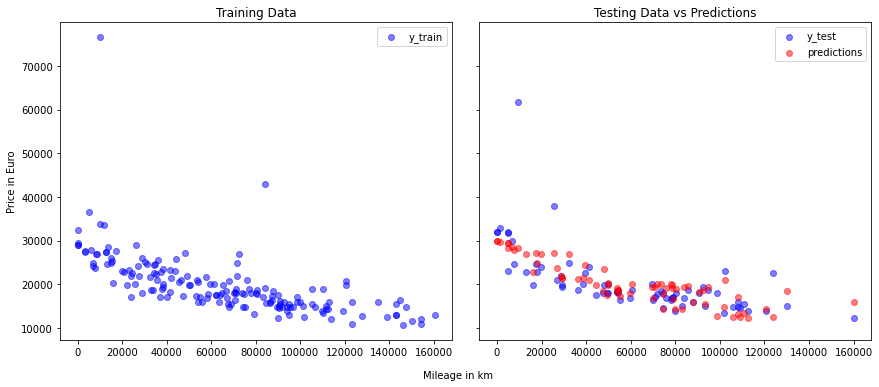

In [18]:
plot_results(X_train,y_train,X_test,y_test,predictions)

### K Neighbours Regression

In [19]:
(X_train,y_train,X_test,y_test,predictions) = predict((MinMaxScaler(), KNeighborsRegressor(n_neighbors=15)),car_data_ML)

Completed in 0.02 seconds
Mean r2 value for all models is 0.63
Mean mape value for all models is 8.8 %


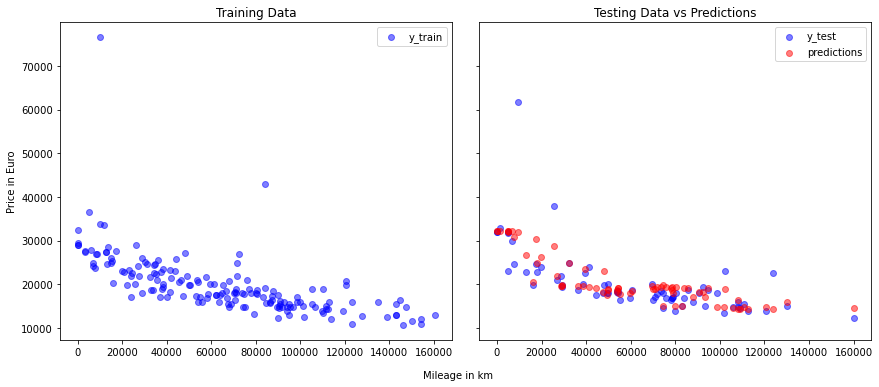

In [20]:
plot_results(X_train,y_train,X_test,y_test,predictions)

### Support Vector Machines Regression

In [21]:
(X_train,y_train,X_test,y_test,predictions) = predict(( MinMaxScaler(), SVR(C=2000)),car_data_ML)

Completed in 0.02 seconds
Mean r2 value for all models is 0.54
Mean mape value for all models is 8.1 %


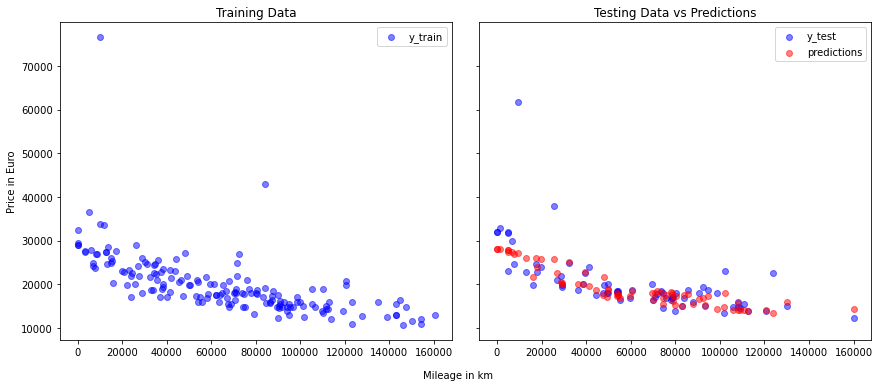

In [22]:
plot_results(X_train,y_train,X_test,y_test,predictions)

### Random Forest Regression

In [23]:
(X_train,y_train,X_test,y_test,predictions) = predict((MinMaxScaler(), RandomForestRegressor(n_estimators=100)),car_data_ML)

Completed in 0.15 seconds
Mean r2 value for all models is 0.59
Mean mape value for all models is 10.4 %


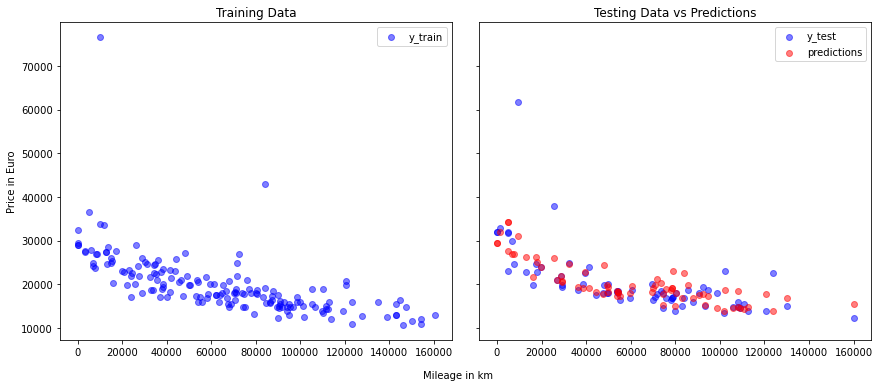

In [24]:
plot_results(X_train,y_train,X_test,y_test,predictions)

### Gradient Boost Regression

In [25]:
(X_train,y_train,X_test,y_test,predictions) = predict((MinMaxScaler(), GradientBoostingRegressor()),car_data_ML)

Completed in 0.04 seconds
Mean r2 value for all models is 0.57
Mean mape value for all models is 10.1 %


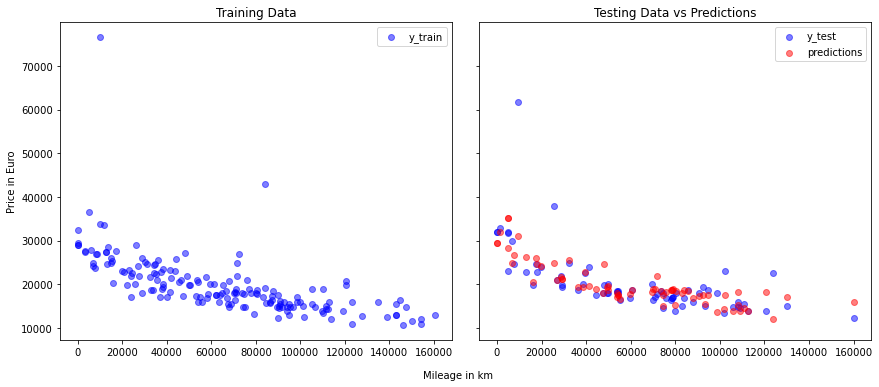

In [26]:
plot_results(X_train,y_train,X_test,y_test,predictions)

# Conclusion
It can be seen that all of the sected algrithm apprximate the data well considering the data quality. The K Neighbors performs among the best of the selected ML algorithms and it is also the fastest. Therefore K Neighbors is chosen for the dateset. 